#Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  #using LinearSVC instead of SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  #using stemmer instead of lemmatizer
from nltk.tokenize import word_tokenize
import string
import warnings
warnings.filterwarnings('ignore')
#set random seed for reproducibility
np.random.seed(42)

#Download required NLTK resources

In [4]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

#Load Dataset

In [5]:
from google.colab import drive
#mount google drive
drive.mount('/content/drive')

#load dataset
df = pd.read_csv('/content/drive/MyDrive/ML_twitter_dataset/twitter.csv',
                 header=None,
                 names=['tweet_record_id', 'entity', 'sentiment', 'tweet_description'])

Mounted at /content/drive


In [6]:
#Display basic information about the dataset
print("\nDataset Information")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows of the dataset:")
print(df.head())


Dataset Information
Number of rows: 74682
Number of columns: 4

Column names:
['tweet_record_id', 'entity', 'sentiment', 'tweet_description']

First few rows of the dataset:
   tweet_record_id       entity sentiment  \
0             2401  Borderlands  Positive   
1             2401  Borderlands  Positive   
2             2401  Borderlands  Positive   
3             2401  Borderlands  Positive   
4             2401  Borderlands  Positive   

                                   tweet_description  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [7]:
#rename columns for clarity based on their content
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_text']

#display unique values in sentiment column
print("\nUnique sentiment values:")
print(df['sentiment'].unique())
print(f"Count of unique sentiment values: {df['sentiment'].nunique()}")
print("\nSentiment value counts:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


Unique sentiment values:
['Positive' 'Neutral' 'Negative' 'Irrelevant']
Count of unique sentiment values: 4

Sentiment value counts:
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


#Data Cleaning

In [8]:
#check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

#remove duplicates if any
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows. New shape: {df.shape}")

#check for and handle missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

if missing_values > 0:
    #fill missing values or drop rows with missing values
    df = df.dropna()
    print(f"Removed rows with missing values. New shape: {df.shape}")

#function to clean text
def fast_clean_text(text):
    if not isinstance(text, str):
        return ""

    #convert to lowercase
    text = text.lower()

    #remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', text)

    #handle negations
    text = re.sub(r"n't", " not", text)

    #remove punctuation and normalize whitespace in one step
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    #tokenize
    tokens = text.split()

    #remove stopwords
    stop_words = set(stopwords.words('english')) - {'no', 'not'}
    tokens = [word for word in tokens if word not in stop_words]

    #use stemming instead of lemmatization
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

#apply cleaning function to tweet text
df['cleaned_text'] = df['tweet_text'].apply(fast_clean_text)

#remove rows with empty cleaned text
empty_text_count = (df['cleaned_text'] == '').sum()
if empty_text_count > 0:
    df = df[df['cleaned_text'] != '']
    print(f"Removed {empty_text_count} rows with empty cleaned text. New shape: {df.shape}")

#encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

#calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['sentiment_encoded']),
    y=df['sentiment_encoded']
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

Number of duplicate rows: 2700
Removed 2700 duplicate rows. New shape: (71982, 4)
Total missing values: 326
Removed rows with missing values. New shape: (71656, 4)
Removed 1565 rows with empty cleaned text. New shape: (70091, 5)


#Feature extraction

In [9]:
#TF-IDF vectorization
print("TF-IDF vectorization")
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.9,
    sublinear_tf=True
)

X = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment_encoded']

#display the shape of the feature matrix
print(f"\nFeature matrix shape: {X.shape}")

TF-IDF vectorization

Feature matrix shape: (70091, 10000)


#Split Data

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (56072, 10000)
Validation set shape: (14019, 10000)


#Linear SVM Model

In [11]:
# First, train a baseline model for comparison
print("Training baseline LinearSVC model")
baseline_model = LinearSVC(random_state=42, max_iter=4000)
baseline_model.fit(X_train, y_train)

#evaluate baseline model
y_train_pred_baseline = baseline_model.predict(X_train)
y_val_pred_baseline = baseline_model.predict(X_val)

train_accuracy_baseline = accuracy_score(y_train, y_train_pred_baseline)
val_accuracy_baseline = accuracy_score(y_val, y_val_pred_baseline)

print(f"Baseline Training Accuracy: {train_accuracy_baseline:.4f}")
print(f"Baseline Validation Accuracy: {val_accuracy_baseline:.4f}")

Training baseline LinearSVC model
Baseline Training Accuracy: 0.8724
Baseline Validation Accuracy: 0.7921


#Apply Cross Validation

In [12]:
#parameter grid
param_distributions = {
    'C': [1.0, 7.0, 7.5, 7.8, 10.0],
    'class_weight': ['balanced', None],
    'dual': [False],
    'loss': ['squared_hinge', 'hinge'],
    'tol': [0.0005, 0.0008, 0.001, 0.0015, 0.002, 0.0025]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#RandomizedSearchCV
random_search = RandomizedSearchCV(
    LinearSVC(random_state=42, max_iter=10000),
    param_distributions=param_distributions,
    n_iter=15,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fit RandomizedSearchCV
random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

#get the best model
best_model = random_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'tol': 0.002, 'loss': 'squared_hinge', 'dual': False, 'class_weight': None, 'C': 7.0}
Best cross-validation score: 0.7829


#Evaluate the tuned model

In [13]:
# Evaluate on training data
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on validation data
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Calculate detailed metrics
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='weighted'
)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average='weighted'
)

print(f"Tuned Model Training Accuracy: {train_accuracy:.4f}")
print(f"Tuned Model Validation Accuracy: {val_accuracy:.4f}")
print(f"\n\nTraining Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"\n\nValidation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

#classification report for validation data
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

Tuned Model Training Accuracy: 0.9021
Tuned Model Validation Accuracy: 0.8036


Training Precision: 0.9024
Training Recall: 0.9021
Training F1-score: 0.9020


Validation Precision: 0.8032
Validation Recall: 0.8036
Validation F1-score: 0.8032

Classification Report (Validation):
              precision    recall  f1-score   support

  Irrelevant       0.78      0.74      0.76      2460
    Negative       0.83      0.85      0.84      4254
     Neutral       0.80      0.78      0.79      3457
    Positive       0.79      0.82      0.80      3848

    accuracy                           0.80     14019
   macro avg       0.80      0.80      0.80     14019
weighted avg       0.80      0.80      0.80     14019



#Learning Curve

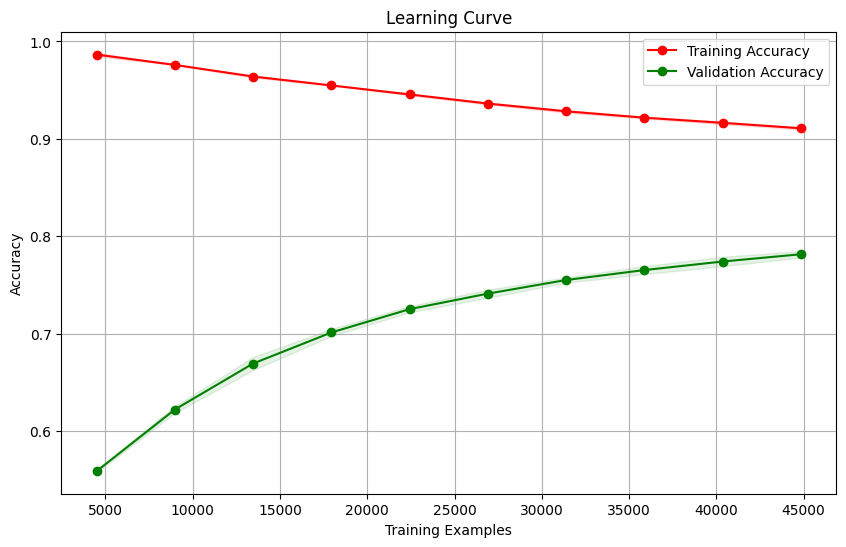

In [14]:
from sklearn.model_selection import learning_curve

#use best_model from your RandomizedSearchCV
model_for_curve = best_model

#define the training set sizes
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model_for_curve,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    verbose=0
)

#calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

#plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color='r')
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color='g')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#Confusion Matrix

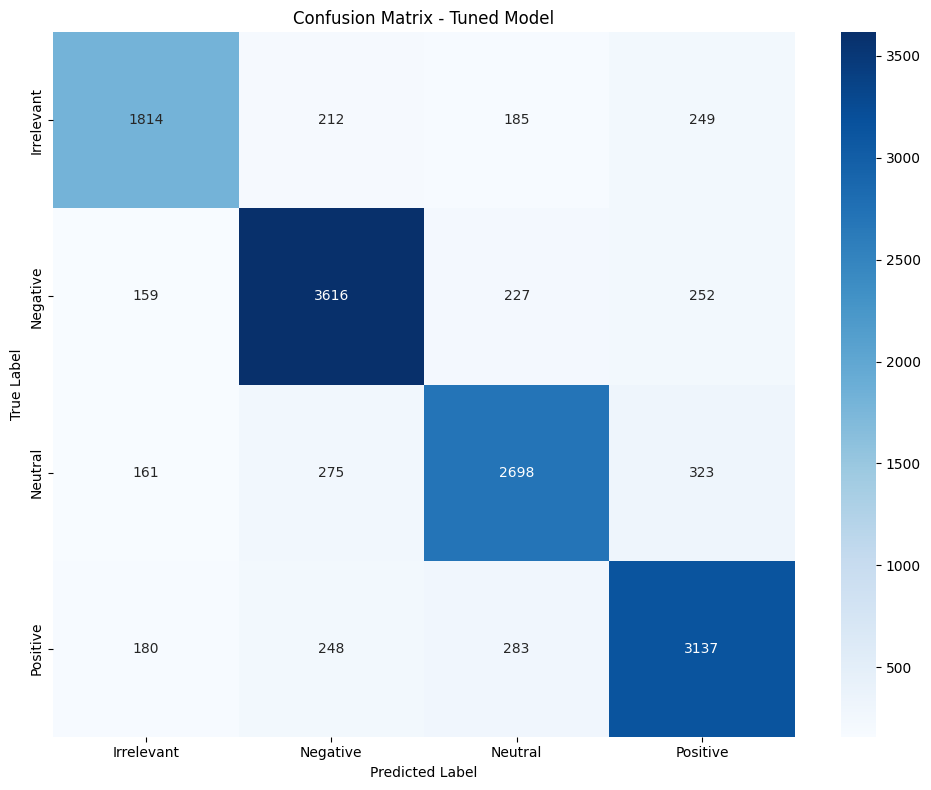

In [15]:
#create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

#plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('tuned_confusion_matrix.png')
plt.show()

#Summary

In [16]:
improvement = (val_accuracy - val_accuracy_baseline) * 100

print("\nSummary")
print(f"Dataset Size: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Sentiment Classes: {', '.join(label_encoder.classes_)}")
print(f"Best Model Parameters: {random_search.best_params_}")
print("\n\nPerformance Comparison:")
print(f"Baseline Training Accuracy: {train_accuracy_baseline:.4f}")
print(f"Baseline Validation Accuracy: {val_accuracy_baseline:.4f}")
print(f"Tuned Model Training Accuracy: {train_accuracy:.4f}")
print(f"Tuned Model Validation Accuracy: {val_accuracy:.4f}")
print(f"Improvement in Validation Accuracy: {improvement:.2f}%")
print(f"\n\nTuned Model Detailed Metrics:")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")


Summary
Dataset Size: 70091 rows, 6 columns
Sentiment Classes: Irrelevant, Negative, Neutral, Positive
Best Model Parameters: {'tol': 0.002, 'loss': 'squared_hinge', 'dual': False, 'class_weight': None, 'C': 7.0}


Performance Comparison:
Baseline Training Accuracy: 0.8724
Baseline Validation Accuracy: 0.7921
Tuned Model Training Accuracy: 0.9021
Tuned Model Validation Accuracy: 0.8036
Improvement in Validation Accuracy: 1.15%


Tuned Model Detailed Metrics:
Validation Precision: 0.8032
Validation Recall: 0.8036
Validation F1-score: 0.8032
